## 1)Поиск и выбор набора данных для построения моделей машинного обучения.

Для анализа был выбран Dataset «Forbes World's Billionaires List 2022».
В нем содержится список людей с различными характеристиками, такими как возраст, доход, пол, сфера деятельности, страна проживания и.т.д, которые можно использовать для подбора собеседников для какого-либо человека из списка.

Характеристики и визуализация данных датасета

In [147]:
from operator import itemgetter
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, AffinityPropagation, OPTICS, DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
sns.set(style="ticks")

In [2]:
data = pd.read_csv('forbes_2022_billionaires.csv', sep=",")

Типы данных столбцов датасета

In [4]:
data.dtypes

rank                      int64
personName               object
age                     float64
finalWorth              float64
year                      int64
month                     int64
category                 object
source                   object
country                  object
state                    object
city                     object
countryOfCitizenship     object
organization             object
selfMade                   bool
gender                   object
birthDate                object
title                    object
philanthropyScore       float64
residenceMsa             object
numberOfSiblings        float64
bio                      object
about                    object
dtype: object

Вывод первых 5 строк датасета

In [5]:
data.head()

,rank,personName,age,finalWorth,year,month,category,source,country,state,...,organization,selfMade,gender,birthDate,title,philanthropyScore,residenceMsa,numberOfSiblings,bio,about
0,1,Elon Musk,50.0,219000.0,2022,4,Automotive,"Tesla, SpaceX",United States,Texas,...,Tesla,True,M,1971-06-28,CEO,1.0,NaN,NaN,Elon Musk is working to revolutionize transpor...,Musk was accepted to a graduate program at Sta...
1,2,Jeff Bezos,58.0,171000.0,2022,4,Technology,Amazon,United States,Washington,...,Amazon,True,M,1964-01-12,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,Jeff Bezos founded e-commerce giant Amazon in ...,"Growing up, Jeff Bezos worked summers on his g..."
2,3,Bernard Arnault & family,73.0,158000.0,2022,4,Fashion & Retail,LVMH,France,NaN,...,LVMH Moët Hennessy Louis Vuitton,False,M,1949-03-05,Chairman and CEO,NaN,NaN,NaN,Bernard Arnault oversees the LVMH empire of so...,"Arnault apparently wooed his wife, Helene Merc..."
3,4,Bill Gates,66.0,129000.0,2022,4,Technology,Microsoft,United States,Washington,...,Bill & Melinda Gates Foundation,True,M,1955-10-28,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,Bill Gates turned his fortune from software fi...,"When Gates was a kid, he spent so much time re..."
4,5,Warren Buffett,91.0,118000.0,2022,4,Finance & Investments,Berkshire Hathaway,United States,Nebraska,...,Berkshire Hathaway,True,M,1930-08-30,CEO,5.0,"Omaha, NE",NaN,"Known as the ""Oracle of Omaha,"" Warren Buffett...","Buffett still lives in the same Omaha, Nebrask..."


Размер датасета

In [11]:
data.shape

(2668, 22)

Проверка на наличие пустых значений

In [12]:
for col in data.columns:
    temp_null_count = data[data[col].isnull()].shape[0]
    print('{} - {}'.format(col, temp_null_count))

rank - 0
personName - 0
age - 86
finalWorth - 0
year - 0
month - 0
category - 0
source - 0
country - 13
state - 1920
city - 44
countryOfCitizenship - 0
organization - 2316
selfMade - 0
gender - 16
birthDate - 99
title - 2267
philanthropyScore - 2272
residenceMsa - 2029
numberOfSiblings - 2541
bio - 0
about - 1106


## 2) Обработка датасета

Заметим, что в датасете в некоторых колонках имеются пропуски. А в некоторых колонках пропущено очень много значений. Поэтому прежде чем начинатьпостроение моделей, обработаем пропуски следующим образом:

В столбцах age, city, country, gender заполним пропуски средствами импьютации библиотеки scikit-learn. Импьютация медианой.

In [3]:
age_data=data[['age']]
age_data

,age
0,50.0
1,58.0
2,73.0
3,66.0
4,91.0
...,...
2663,66.0
2664,59.0
2665,57.0
2666,43.0


In [4]:
imputerAge = SimpleImputer(missing_values=np.nan, strategy='median')
full_age = imputerAge.fit_transform(age_data)
full_age

array([[50.],
       [58.],
       [73.],
       ...,
       [57.],
       [43.],
       [59.]])

In [5]:
np.unique(full_age)

array([ 19.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98., 100.])

In [6]:
data['age'] = full_age.reshape(-1)
data.head()

,rank,personName,age,finalWorth,year,month,category,source,country,state,...,organization,selfMade,gender,birthDate,title,philanthropyScore,residenceMsa,numberOfSiblings,bio,about
0,1,Elon Musk,50.0,219000.0,2022,4,Automotive,"Tesla, SpaceX",United States,Texas,...,Tesla,True,M,1971-06-28,CEO,1.0,NaN,NaN,Elon Musk is working to revolutionize transpor...,Musk was accepted to a graduate program at Sta...
1,2,Jeff Bezos,58.0,171000.0,2022,4,Technology,Amazon,United States,Washington,...,Amazon,True,M,1964-01-12,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,Jeff Bezos founded e-commerce giant Amazon in ...,"Growing up, Jeff Bezos worked summers on his g..."
2,3,Bernard Arnault & family,73.0,158000.0,2022,4,Fashion & Retail,LVMH,France,NaN,...,LVMH Moët Hennessy Louis Vuitton,False,M,1949-03-05,Chairman and CEO,NaN,NaN,NaN,Bernard Arnault oversees the LVMH empire of so...,"Arnault apparently wooed his wife, Helene Merc..."
3,4,Bill Gates,66.0,129000.0,2022,4,Technology,Microsoft,United States,Washington,...,Bill & Melinda Gates Foundation,True,M,1955-10-28,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,Bill Gates turned his fortune from software fi...,"When Gates was a kid, he spent so much time re..."
4,5,Warren Buffett,91.0,118000.0,2022,4,Finance & Investments,Berkshire Hathaway,United States,Nebraska,...,Berkshire Hathaway,True,M,1930-08-30,CEO,5.0,"Omaha, NE",NaN,"Known as the ""Oracle of Omaha,"" Warren Buffett...","Buffett still lives in the same Omaha, Nebrask..."


Поля country, gender заполним наиболее частыми значаниями

In [7]:
country =  data[['country']]
gender =  data[['gender']]
imp_ccg = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [8]:
full_country = imp_ccg.fit_transform(country)
full_country

array([['United States'],
       ['United States'],
       ['France'],
       ...,
       ['China'],
       ['China'],
       ['China']], dtype=object)

In [9]:
full_gender = imp_ccg.fit_transform(gender)
full_gender

array([['M'],
       ['M'],
       ['M'],
       ...,
       ['M'],
       ['F'],
       ['M']], dtype=object)

In [10]:
data['country'] = full_country.reshape(-1)
data['gender'] = full_gender.reshape(-1)
data.head()

,rank,personName,age,finalWorth,year,month,category,source,country,state,...,organization,selfMade,gender,birthDate,title,philanthropyScore,residenceMsa,numberOfSiblings,bio,about
0,1,Elon Musk,50.0,219000.0,2022,4,Automotive,"Tesla, SpaceX",United States,Texas,...,Tesla,True,M,1971-06-28,CEO,1.0,NaN,NaN,Elon Musk is working to revolutionize transpor...,Musk was accepted to a graduate program at Sta...
1,2,Jeff Bezos,58.0,171000.0,2022,4,Technology,Amazon,United States,Washington,...,Amazon,True,M,1964-01-12,Entrepreneur,1.0,"Seattle-Tacoma-Bellevue, WA",NaN,Jeff Bezos founded e-commerce giant Amazon in ...,"Growing up, Jeff Bezos worked summers on his g..."
2,3,Bernard Arnault & family,73.0,158000.0,2022,4,Fashion & Retail,LVMH,France,NaN,...,LVMH Moët Hennessy Louis Vuitton,False,M,1949-03-05,Chairman and CEO,NaN,NaN,NaN,Bernard Arnault oversees the LVMH empire of so...,"Arnault apparently wooed his wife, Helene Merc..."
3,4,Bill Gates,66.0,129000.0,2022,4,Technology,Microsoft,United States,Washington,...,Bill & Melinda Gates Foundation,True,M,1955-10-28,Cofounder,4.0,"Seattle-Tacoma-Bellevue, WA",NaN,Bill Gates turned his fortune from software fi...,"When Gates was a kid, he spent so much time re..."
4,5,Warren Buffett,91.0,118000.0,2022,4,Finance & Investments,Berkshire Hathaway,United States,Nebraska,...,Berkshire Hathaway,True,M,1930-08-30,CEO,5.0,"Omaha, NE",NaN,"Known as the ""Oracle of Omaha,"" Warren Buffett...","Buffett still lives in the same Omaha, Nebrask..."


Удалим столбцы state, organization, birthDate, title, philanthropyScore, residenceMsa, numberOfSiblings, about, year, month, city, personName, countryOfCitizenship, source, поскольку они либо не представляют интереса для задачи поиска рекомендаций, либо имеют более 60% пропущенных значений. 

In [11]:
data.drop(['state'], inplace=True, axis=1)
data.drop(['organization'], inplace=True, axis=1)
data.drop(['birthDate'], inplace=True, axis=1)
data.drop(['title'], inplace=True, axis=1)
data.drop(['philanthropyScore'], inplace=True, axis=1)
data.drop(['residenceMsa'], inplace=True, axis=1)
data.drop(['numberOfSiblings'], inplace=True, axis=1)
data.drop(['about'], inplace=True, axis=1)
data.drop(['year'], inplace=True, axis=1)
data.drop(['month'], inplace=True, axis=1)
data.drop(['bio'], inplace=True, axis=1)
data.drop(['source'], inplace=True, axis=1)
data.drop(['personName'], inplace=True, axis=1)
data.drop(['countryOfCitizenship'], inplace=True, axis=1)
data.drop(['city'], inplace=True, axis=1)
data.drop(['rank'], inplace=True, axis=1)
data.head()

,age,finalWorth,category,country,selfMade,gender
0,50.0,219000.0,Automotive,United States,True,M
1,58.0,171000.0,Technology,United States,True,M
2,73.0,158000.0,Fashion & Retail,France,False,M
3,66.0,129000.0,Technology,United States,True,M
4,91.0,118000.0,Finance & Investments,United States,True,M


Поскольку все категориальные столбцы потребуется закодировать, на данном этапе необходимо провести визуализацию данных, пока они представляют понятный для пользователя вид.

Корелляционная матрица

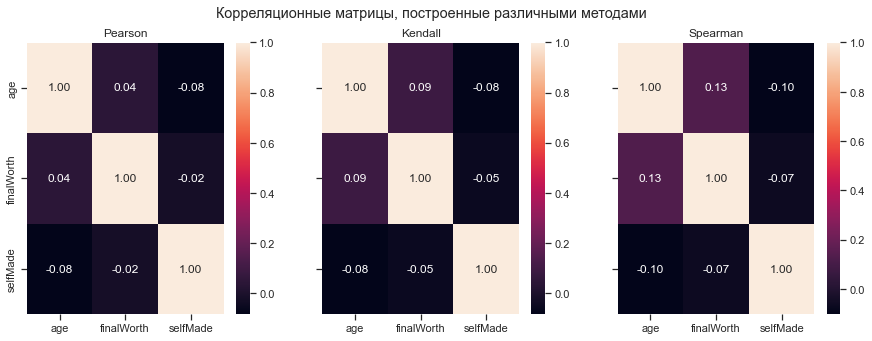

In [12]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
sns.heatmap(data.corr(method='pearson'), ax=ax[0], annot=True, fmt='.2f')
sns.heatmap(data.corr(method='kendall'), ax=ax[1], annot=True, fmt='.2f')
sns.heatmap(data.corr(method='spearman'), ax=ax[2], annot=True, fmt='.2f')
fig.suptitle('Корреляционные матрицы, построенные различными методами')
ax[0].title.set_text('Pearson')
ax[1].title.set_text('Kendall')
ax[2].title.set_text('Spearman')

Во всей матрице корелляций все коэффициенты корелляции достаточно малы, из чего можно сделать вывод, что все признаки слабо коррелируют, выбранный датасет плохо бы подошел для моделей машинного обучения. Однако цель нашего исследования - постараться создать лучшую возможную модель для конкретного датасета.

## 3) Визуализация датасета

Построим графики и диаграммы необходимых для понимания структуры данных.

В какой стране больше всего миллиардеров

In [28]:
len(data["country"].unique())

73

In [29]:
data_country = data.groupby("country")

In [30]:
data_country_count = pd.DataFrame(
    data_country.size().sort_values(ascending=False), columns=["Count"])

In [31]:
data_country_count.head()

,Count
country,
United States,761
China,571
India,159
Germany,112
United Kingdom,85


C:\Users\Alexandra\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Count', ylabel='country'>

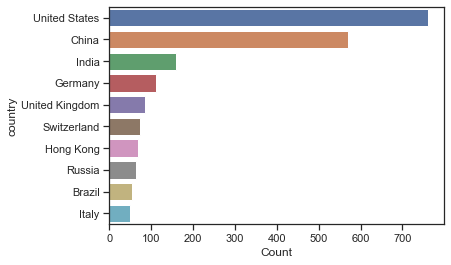

In [33]:
sns.barplot(data_country_count["Count"][:10], data_country_count.index[:10])

В какой отрасли больше всего миллиардеров

In [34]:
data["category"].unique()

array(['Automotive', 'Technology', 'Fashion & Retail',
       'Finance & Investments', 'Diversified', 'Media & Entertainment',
       'Telecom', 'Food & Beverage', 'Logistics', 'Real Estate',
       'Metals & Mining', 'Manufacturing', 'Gambling & Casinos',
       'Healthcare', 'Service', 'Energy', 'Construction & Engineering',
       'Sports'], dtype=object)

In [35]:
data["category"]=data["category"].apply(lambda x:x.replace(" ","")).\
    apply(lambda x:x.replace("&","_"))

In [36]:
data["category"].unique()

array(['Automotive', 'Technology', 'Fashion_Retail',
       'Finance_Investments', 'Diversified', 'Media_Entertainment',
       'Telecom', 'Food_Beverage', 'Logistics', 'RealEstate',
       'Metals_Mining', 'Manufacturing', 'Gambling_Casinos', 'Healthcare',
       'Service', 'Energy', 'Construction_Engineering', 'Sports'],
      dtype=object)

In [37]:
data_category = data.groupby("category").size()

In [38]:
data_category.head()

category
Automotive                   70
Construction_Engineering     46
Diversified                 180
Energy                       95
Fashion_Retail              250
dtype: int64

In [39]:
data_category = data_category.to_frame()
data_category.head()

,0
category,
Automotive,70
Construction_Engineering,46
Diversified,180
Energy,95
Fashion_Retail,250


In [40]:
data_category=data_category.rename(columns = {0:"Count"}).\
    sort_values(by = "Count", ascending=False)

In [41]:
data_category.head()

,Count
category,
Finance_Investments,392
Technology,343
Manufacturing,337
Fashion_Retail,250
Healthcare,217


C:\Users\Alexandra\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Count', ylabel='category'>

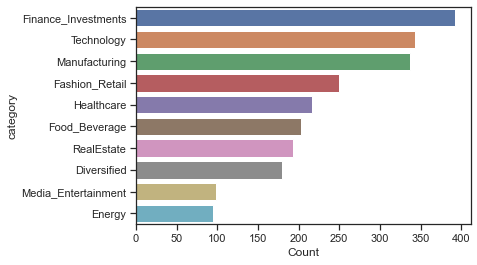

In [42]:
sns.barplot(data_category["Count"][:10], data_category.index[:10])

Взаимосвязь между деньгами и возрастом

<AxesSubplot:xlabel='age', ylabel='finalWorth'>

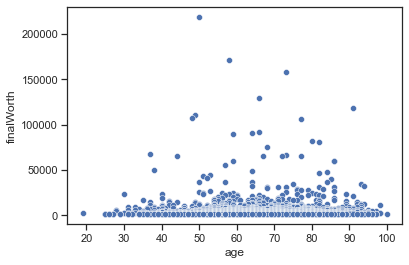

In [43]:
sns.scatterplot(data = data, x="age", y="finalWorth")

Распределение по возрасту

<AxesSubplot:xlabel='age', ylabel='Count'>

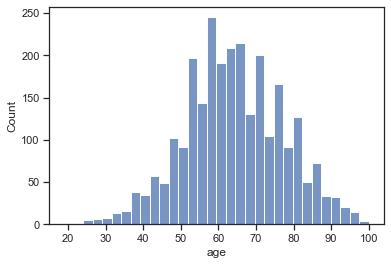

In [44]:
sns.histplot(data = data, x="age")

## 4) Кодирование данных

Для методов кластеризации подходят только числовые данные, поэтому придется провести формирование вспомогательных признаков, а именно, преобразование категориальных признаков в числовые. Для этого воспользуемся методом — one-hot.

In [13]:
data['gender'] = data['gender'].replace(to_replace='M', value=1)
data['gender'] = data['gender'].replace(to_replace='F', value=0)
data.head()

,age,finalWorth,category,country,selfMade,gender
0,50.0,219000.0,Automotive,United States,True,1
1,58.0,171000.0,Technology,United States,True,1
2,73.0,158000.0,Fashion & Retail,France,False,1
3,66.0,129000.0,Technology,United States,True,1
4,91.0,118000.0,Finance & Investments,United States,True,1


In [14]:
len(data["country"].unique())

73

In [15]:
len(data["category"].unique())

18

In [16]:
ohe = OneHotEncoder(sparse=False)
ohe_ftrs = ohe.fit_transform(data['country'].values.reshape(-1,1))
tmp = pd.DataFrame(ohe_ftrs, columns = ['country=' + str(i) for i in range(ohe_ftrs.shape[1])])
data = pd.concat([data, tmp], axis=1)
data

,age,finalWorth,category,country,selfMade,gender,country=0,country=1,country=2,country=3,...,country=63,country=64,country=65,country=66,country=67,country=68,country=69,country=70,country=71,country=72
0,50.0,219000.0,Automotive,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,58.0,171000.0,Technology,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,73.0,158000.0,Fashion & Retail,France,False,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66.0,129000.0,Technology,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,91.0,118000.0,Finance & Investments,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,66.0,1000.0,Manufacturing,China,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2664,59.0,1000.0,Technology,China,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2665,57.0,1000.0,Manufacturing,China,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2666,43.0,1000.0,Energy,China,True,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
ohe = OneHotEncoder(sparse=False)
ohe_ftrs = ohe.fit_transform(data['category'].values.reshape(-1,1))
tmp = pd.DataFrame(ohe_ftrs, columns = ['category=' + str(i) for i in range(ohe_ftrs.shape[1])])
data = pd.concat([data, tmp], axis=1)
data

,age,finalWorth,category,country,selfMade,gender,country=0,country=1,country=2,country=3,...,category=8,category=9,category=10,category=11,category=12,category=13,category=14,category=15,category=16,category=17
0,50.0,219000.0,Automotive,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58.0,171000.0,Technology,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,73.0,158000.0,Fashion & Retail,France,False,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66.0,129000.0,Technology,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,91.0,118000.0,Finance & Investments,United States,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,66.0,1000.0,Manufacturing,China,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2664,59.0,1000.0,Technology,China,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2665,57.0,1000.0,Manufacturing,China,True,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2666,43.0,1000.0,Energy,China,True,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
data.drop(['country'], inplace=True, axis=1)
data.drop(['category'], inplace=True, axis=1)

Масштабирование столбца с финансовым состоянием.

In [19]:
data['finalWorth'] = data['finalWorth'].astype('int64')

In [20]:
sc1 = MinMaxScaler()
data_array = sc1.fit_transform(data[['finalWorth']])
data_age = sc1.fit_transform(data[['age']])

In [21]:
data_age

array([[0.38271605],
       [0.48148148],
       [0.66666667],
       ...,
       [0.4691358 ],
       [0.2962963 ],
       [0.49382716]])

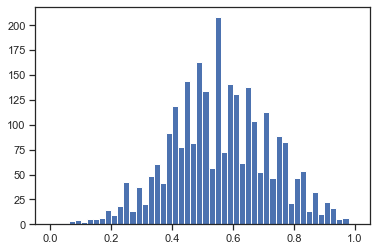

In [22]:
plt.hist(data_age, 50)
plt.show()

In [23]:
data_array

array([[1.        ],
       [0.77981651],
       [0.72018349],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

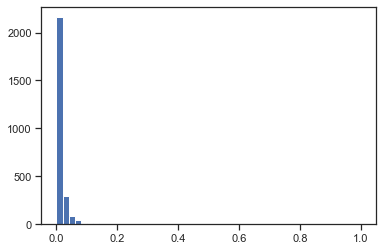

In [24]:
plt.hist(data_array, 50)
plt.show()

In [25]:
data.drop(['finalWorth'], inplace=True, axis=1)
data['finalWorth'] = data_array
data.drop(['age'], inplace=True, axis=1)
data['age'] = data_age

In [26]:
data.head()

,selfMade,gender,country=0,country=1,country=2,country=3,country=4,country=5,country=6,country=7,...,category=10,category=11,category=12,category=13,category=14,category=15,category=16,category=17,finalWorth,age
0,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.382716
1,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.779817,0.481481
2,False,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.720183,0.666667
3,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.587156,0.580247
4,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.536697,0.888889


Коррекция данных датасета закончена. 

## 5) Выбор наиболее подходящих моделей для решения задачи, выбор метрик для последующей оценки качества моделей.

Для создания системы рекомендации собеседников по интересам необходимо решить задачу кластеризации списка людей, которые могут быть пользователями какого-либо приложения для общения, по их характеристикам. Рассмотрим 5 наиболее интересных методов кластеризации библиотеки sklearn: KMeans,  AgglomerativeClustering, Affinity Propagation, OPTICS, Birch.

1) KMeans  - Алгоритм К-средних, был выбран как самый популярный и простой впонимании алгоритм кластеризации. Универсальный, любой размер кластеров, плоская геометрия, не слишком много кластеров. В качестве метрики используется дистанция между точками.

2) AgglomerativeClustering -  Метод выбрат тк он использует метрику дистанция между точками и в нем возможно осуществить ограничение связей. При выполнении алгоритма создаются вложенные кластеры путем их последовательного слияния или разделения. Эта иерархия кластеров представлена в виде дерева (или дендрограммы). Корень дерева — это уникальный кластер, который собирает все образцы, а листья — это кластеры только с одним образцом.

3) Affinity Propagation - этот метод выбран, поскольку он рассчитывает количество кластеров на основе предоставленных данных, что очень подходит под условие нашей задачи. Он создает кластеры, отправляя сообщения между парами образцов до схождения. Затем набор данных описывается с использованием небольшого количества образцов, которые определяются как наиболее репрезентативные для других образцов. Сообщения, отправляемые между парами, представляют пригодность одного образца быть образцом другого, который обновляется в ответ на значения из других пар. Это обновление происходит итеративно до сходимости, после чего выбираются окончательные образцы и, следовательно, дается окончательная кластеризация.

4) DBSCAN - Метод выбран тк в нем может быть неравномерный размер кластеров. Метод рассматривает кластеры , как участки высокой плотности , разделенных районах с низкой плотностью. Из-за этого довольно общего представления кластеры, обнаруженные с помощью DBSCAN, могут иметь любую форму, в отличие от k-средних, которое предполагает, что кластеры имеют выпуклую форму.

5) Birch - Критериями для выбора данного метода был большой объем данных, удаление выбросов, сокращение данных. Строит дерево, называемое деревом функций кластеризации (CFT). Данные по существу сжимаются с потерями до набора узлов Clustering Feature (CF Nodes). Узлы CF имеют ряд подкластеров, называемых подкластерами функций кластеризации (подкластеры CF), и эти подкластеры CF, расположенные в нетерминальных узлах CF, могут иметь узлы CF в качестве дочерних. Подкластеры CF содержат необходимую информацию для кластеризации, что избавляет от необходимости хранить все входные данные в памяти.

Для последующей оценки качества моделей выбраны 3 метрики: Коэффициент силуэта, Индекс Калински-Харабаса, Индекс Дэвиса-Болдина. Выбор этих метрик обосновывается тем, что это в библиотеке sklearn существует только 3 метрики для оценки качества моделей клсастеризации, которые не требуют для выполнения алгоритма проверки известности истинных меток классов. В начем случае модель кластеризуется первично и истинных меток классов не имеет.

1) Индекс Дэвиса-Болдина означает среднее «сходство» между кластерами, где сходство — это мера, которая сравнивает расстояние между кластерами с размером самих кластеров. Ноль — это наименьший возможный результат. Значения, близкие к нулю, указывают на лучшее разделение.

2) Индекс Калински-Харабаса представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для всех кластеров (где дисперсия определяется как сумма квадратов расстояний). Оценка выше, когда кластеры плотные и хорошо разделенные, что относится к стандартной концепции кластера.

3) Коэффициент силуэта является примером такой оценки, где более высокий показатель коэффициента силуэта относится к модели с лучше определенными кластерами. Оценка ограничена от -1 за неправильную кластеризацию до +1 за высокоплотную кластеризацию. Баллы около нуля указывают на перекрывающиеся кластеры.


Для оценки гиперпараметра количества кластеров в некоторых из выбранных методов кластеризации будем использовать "правило локтя".

Полученные результаты будут проверены на качество кластеризации и визуализированы. Лучший метод кластеризации будет рекомендован к использованию.

## 6) Построение базовых решений для выбранных моделей, подбор гиперпараметров, оценка моделей выбранными способами

### Метод k-средних

Для работы с алгоритмами кластеризации преобразуем данные из датафрейма в список списков.

In [55]:
data_array=data.to_numpy()

In [56]:
data_array

array([[True, 1, 0.0, ..., 0.0, 0.9999999999999999, 0.38271604938271603],
       [True, 1, 0.0, ..., 0.0, 0.7798165137614679, 0.48148148148148145],
       [False, 1, 0.0, ..., 0.0, 0.7201834862385321, 0.6666666666666667],
       ...,
       [True, 1, 0.0, ..., 0.0, 0.0, 0.46913580246913583],
       [True, 0, 0.0, ..., 0.0, 0.0, 0.2962962962962962],
       [True, 1, 0.0, ..., 0.0, 0.0, 0.4938271604938271]], dtype=object)

In [57]:
type(data_array)

numpy.ndarray

В качестве балового решения попробуем использовать разбиение на 3 кластера.

In [58]:
cluster_results = []
%time temp_cluster = KMeans(n_clusters=3).fit_predict(data_array)
cluster_results.append(temp_cluster)
result_KMeans_3  = cluster_results

Wall time: 150 ms


In [59]:
result_KMeans_3

[array([0, 0, 2, ..., 1, 1, 1])]

Проверим  работу метода, выведем уникальные значения полученного листа и построим график отображающий распределение личночтей по кластерам.

In [60]:
uni = np.unique(result_KMeans_3)
uni

array([0, 1, 2])

Видим, что алгоритм создал всего 3 кластера

<AxesSubplot:>

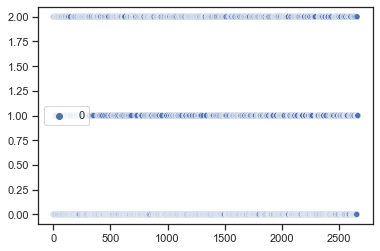

In [61]:
sns.scatterplot(data=result_KMeans_3)

Мы видим, что все множество пользователей равномерно распределенопо 0, 1 и 2 кластерам. С точки зрения поиска собеседников по интересам данный результат, как минимум выглядит не точно. Недостаточно кластеров для оценки интересов. Поэтому мы воспользуемся методом оценки гиперпараметра - количества кластеров для разбиения. 

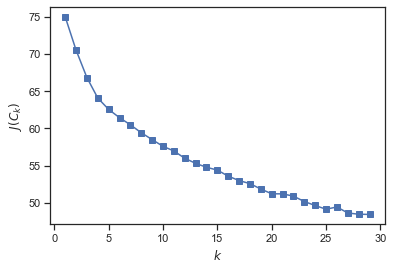

In [62]:
inertia = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_array)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.plot(range(1, 30), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Примем точкой резкого уменьшения инерции k=4

Попробуем разбить данные на 4 кластеров

In [63]:
cluster_results = []
%time temp_cluster = KMeans(n_clusters=4).fit_predict(data_array)
cluster_results.append(temp_cluster)
result_KMeans_4  = cluster_results

Wall time: 168 ms


In [64]:
result_KMeans_4

[array([1, 1, 2, ..., 0, 0, 0])]

In [65]:
np.unique(result_KMeans_4)

array([0, 1, 2, 3])

<AxesSubplot:>

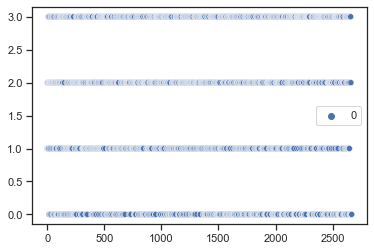

In [66]:
sns.scatterplot(data=result_KMeans_4)

Теперь оценим поcтроенную модель

In [67]:
preds = KMeans(n_clusters=4).fit_predict(data_array)
score = silhouette_score(data_array, preds)
print("For 4 clusters, silhouette score is {})".format(score))

For 4 clusters, silhouette score is 0.16270998062517955)


In [68]:
score = calinski_harabasz_score(data_array, preds)
print("Calinski_harabasz score is {})".format(score))

Calinski_harabasz score is 328.4851223383645)


In [69]:
kmeans = KMeans(n_clusters=14, random_state=1).fit(data_array)
labels = kmeans.labels_
davies_bouldin_score(data_array, labels)

2.0873511826740603

Все метрики имеют низкие показатели оценки. Данная модель имеет плохое качество.

### Иерархическая кластеризация (AgglomerativeClustering)

In [70]:
%time result_AgglomerativeClustering = AgglomerativeClustering(n_clusters=3).fit(data_array)

Wall time: 596 ms


In [71]:
result_AgglomerativeClustering.labels_

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

In [72]:
np.unique(result_AgglomerativeClustering.labels_)

array([0, 1, 2], dtype=int64)

<AxesSubplot:>

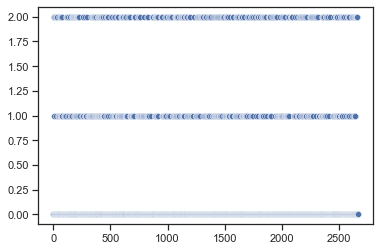

In [73]:
sns.scatterplot(data=result_AgglomerativeClustering.labels_)

Мы видим, опять же, что 3 кластеров явно не достаточно для корректного разбиения, поэтому перейдем к подбору гиперпараметра.

In [74]:
i = list(range(2, 200))
silhouette_scores = []
for k in range(2, 200):
    silhouette_scores.append(silhouette_score(data_array, AgglomerativeClustering(n_clusters=k).fit_predict(data_array)))

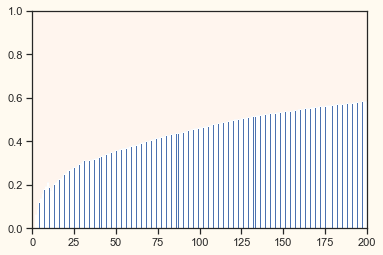

In [75]:
fig, ax = plt.subplots()
ax.axis([0,200,0,1])
ax.bar(i, silhouette_scores)
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')

plt.show()

In [76]:
silhouette_scores

[0.06496917194554404,
 0.08864468789375624,
 0.12056533946432697,
 0.14007065356520623,
 0.16270781426546882,
 0.18271565084209732,
 0.1961738863623816,
 0.21138755739382098,
 0.19149225554741578,
 0.17388480695482447,
 0.19188624824870223,
 0.20339517474089092,
 0.21207682695926855,
 0.2205913563980438,
 0.22597804863199686,
 0.23227122421852944,
 0.2414848911010768,
 0.248957197797149,
 0.25441386788356773,
 0.26867503513259816,
 0.2684519557079025,
 0.272329647567775,
 0.27631084636711123,
 0.28032702810515175,
 0.28412743663424816,
 0.28945193198309954,
 0.29560301753497276,
 0.3009975793566459,
 0.3085551996765731,
 0.3118652014722474,
 0.3075546816240221,
 0.3092713534770123,
 0.3120673869744308,
 0.314337452898232,
 0.3192169449291871,
 0.31658124775336116,
 0.32111366471794506,
 0.32499109421383426,
 0.3271913379800343,
 0.33078132540684885,
 0.3355175751985092,
 0.33813346504731406,
 0.3426461049655769,
 0.3460225101086838,
 0.3483678703229542,
 0.3498703271361862,
 0.35223765

В данном случае рост коэф. силуэта наблюдается при увеличении количества кластеров. Для рекомендательной системы собеседников удобно чтобы в одном кластеренаходилось мимнимум 10 человек, поэтому макс. возможное значение k = 200. Следовательно, перестроим модель для этого значения гиперпараметра.

In [85]:
%time result_AgglomerativeClustering200 = AgglomerativeClustering(n_clusters=200).fit(data_array)

Wall time: 610 ms


In [86]:
result_AgglomerativeClustering200.labels_

array([ 58,  52, 143, ...,  83,  13,  83], dtype=int64)

<AxesSubplot:>

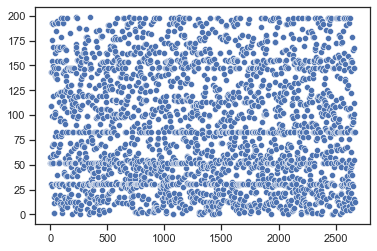

In [87]:
sns.scatterplot(data=result_AgglomerativeClustering200.labels_)

Теперь оценим построенную модель

In [88]:
preds = AgglomerativeClustering(n_clusters=200).fit_predict(data_array)
score = silhouette_score(data_array, preds)
print("For 14 clusters, silhouette score is {})".format(score))

For 14 clusters, silhouette score is 0.5865787674901431)


In [89]:
score = calinski_harabasz_score(data_array, preds)
print("Calinski_harabasz score is {})".format(score))

Calinski_harabasz score is 76.34544726476048)


In [90]:
score = davies_bouldin_score(data_array, preds)
print("Davies_bouldin score is {})".format(score))

Davies_bouldin score is 1.3144772596687933)


В данном методе показатель 1 метрики имеет хорошее значение, показатели 2 и 3 метрик имеют средние значения.

###  Affinity Propagation

In [91]:
%time result_AffinityPropagation = AffinityPropagation(random_state=0, max_iter=500, damping = 0.9).fit(data_array)

Wall time: 34.7 s


In [92]:
data_array

array([[True, 1, 0.0, ..., 0.0, 0.9999999999999999, 0.38271604938271603],
       [True, 1, 0.0, ..., 0.0, 0.7798165137614679, 0.48148148148148145],
       [False, 1, 0.0, ..., 0.0, 0.7201834862385321, 0.6666666666666667],
       ...,
       [True, 1, 0.0, ..., 0.0, 0.0, 0.46913580246913583],
       [True, 0, 0.0, ..., 0.0, 0.0, 0.2962962962962962],
       [True, 1, 0.0, ..., 0.0, 0.0, 0.4938271604938271]], dtype=object)

In [93]:
result_AffinityPropagation.labels_

array([ 15,   7,  65, ..., 122,  98, 122], dtype=int64)

In [94]:
np.unique(result_AffinityPropagation.labels_)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

<AxesSubplot:>

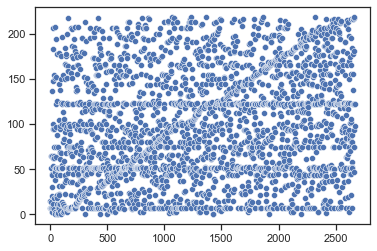

In [95]:
sns.scatterplot(data=result_AffinityPropagation.labels_)

Для наших данных метод AffinityPropagation рассчитал оптимальным создать 220 кластеров. На графике видны более плотные области для некоторых кластеров.

Оценим полученный результат

In [96]:
preds = AffinityPropagation(random_state=0, max_iter=500, damping = 0.9).fit_predict(data_array)
score = silhouette_score(data_array, preds)
print("Silhouette score is {})".format(score))

Silhouette score is 0.5605702711916941)


In [97]:
score = calinski_harabasz_score(data_array, result_AffinityPropagation.labels_)
print("Calinski_harabasz score is {})".format(score))

Calinski_harabasz score is 64.34840886382715)


In [98]:
score = davies_bouldin_score(data_array, result_AffinityPropagation.labels_)
print("Davies_bouldin score is {})".format(score))

Davies_bouldin score is 1.217626779852927)


В данном методе показатель 1 метрики имеет хорошее значение, показатели 2 и 3 метрик имеют средние значения.

### Birch

In [114]:
%time result_Birch = Birch(n_clusters=3).fit(data_array)

Wall time: 302 ms


In [115]:
result_Birch.labels_

array([0, 2, 0, ..., 0, 2, 0], dtype=int64)

In [116]:
np.unique(result_Birch.labels_)

array([0, 1, 2], dtype=int64)

<AxesSubplot:>

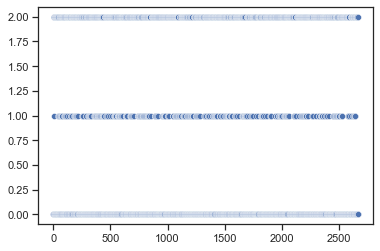

In [117]:
sns.scatterplot(data=result_Birch.labels_)

Данный гафик поход на график результата кластеризации модели, обученной по методу AgglomerativeClustering при  таком же значении гиперпараметра. Подберем лучшее значение гиперпараметра. Через коэффициент силуэта.

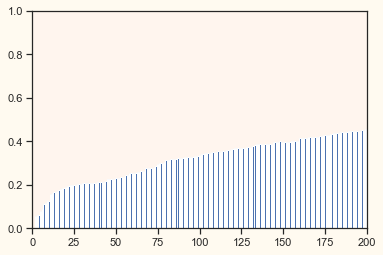

In [120]:
i = list(range(2, 200))
silhouette_scores = []
for k in range(2, 200):
    silhouette_scores.append(silhouette_score(data_array, Birch(n_clusters=k).fit_predict(data_array)))

fig, ax = plt.subplots()
ax.axis([0,200,0,1])
ax.bar(i, silhouette_scores)
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')

plt.show()

В данном случае рост коэф. силуэта наблюдается при увеличении количества кластеров. Для рекомендательной системы собеседников удобно чтобы в одном кластеренаходилось мимнимум 10 человек, поэтому макс. возможное значение k = 200. Следовательно, перестроим модель для этого значения гиперпараметра.

In [139]:
%time result_Birch = Birch(n_clusters=200).fit(data_array)

Wall time: 306 ms


In [140]:
result_Birch.labels_

array([128,  51,  90, ..., 151, 143, 151], dtype=int64)

<AxesSubplot:>

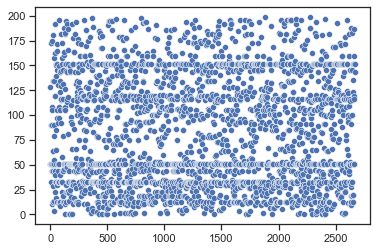

In [141]:
sns.scatterplot(data=result_Birch.labels_)

Данный гафик поход на график результата кластеризации модели, обученной по методу AgglomerativeClustering при таком же значении гиперпараметра. Оценим модель с помощью метрик.

In [142]:
score = silhouette_score(data_array, result_Birch.labels_)
print("Silhouette score is {})".format(score))

Silhouette score is 0.454808671934264)


In [143]:
score = calinski_harabasz_score(data_array, result_Birch.labels_)
print("Calinski_harabasz score is {})".format(score))

Calinski_harabasz score is 45.96685633981852)


In [144]:
score = davies_bouldin_score(data_array, result_Birch.labels_)
print("Davies_bouldin score is {})".format(score))

Davies_bouldin score is 1.2414447288298356)


В данном методе показатели метрик имеют среднее значения.

### DBSCAN

In [158]:
%time result_DBSCAN = DBSCAN(min_samples=3).fit(data_array)

Wall time: 175 ms


In [159]:
result_DBSCAN.labels_

array([-1,  0, -1, ..., 22, 34, 22], dtype=int64)

In [160]:
np.unique(result_DBSCAN.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

<AxesSubplot:>

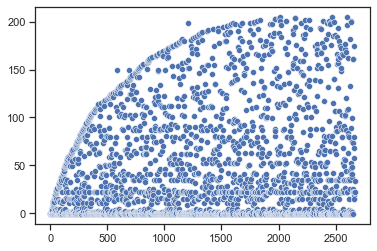

In [161]:
sns.scatterplot(data=result_DBSCAN.labels_)

Данный метод вичислил, что наилучшим значением гиперпараметра будет k = 206. График этого метода значительно отличается от предыдущих. Чем выше ранг человека в списке (чем меньше его номер в списке), тем больше вероятность того, что что этот человек попадет в начальные коастеры. Оценим модель с помощью метрик.

In [165]:
score = silhouette_score(data_array, result_DBSCAN.labels_)
print("Silhouette score is {})".format(score))

Silhouette score is 0.5682758331644328)


In [166]:
score = calinski_harabasz_score(data_array, result_DBSCAN.labels_)
print("Calinski_harabasz score is {})".format(score))

Calinski_harabasz score is 32.75950400067399)


In [167]:
score = davies_bouldin_score(data_array, result_DBSCAN.labels_)
print("Davies_bouldin score is {})".format(score))

Davies_bouldin score is 1.0872406145334894)


Оценки данной модели хорошие. 1 и 3 метрики имеют показатель выше среднего. 2 метрика имеет среднюю оценку.

## 7) Формирование выводов о качестве построенных моделей на основе выбранных метрик.

In [168]:
tabledata = [["KMeans", "0,168", 0.16, 328, 2.09],
         ["AgglomerativeClustering", "0,610", 0.59, 76, 1.31],
         ["Affinity Propagation", "34,7", 0.56, 64, 1.22],
         ["Birch", "0,306", 0.45, 46, 1.24],
         ["DBSCAN", "0,175", 0.57, 32, 1.09]]
tabledata
pd.DataFrame(tabledata, columns=["Метод","Время выполнения(с)", "Коэффициент силуэта", "Индекс Калински-Харабаса", "Индекс Дэвиса-Болдина"])

,Метод,Время выполнения(с),Коэффициент силуэта,Индекс Калински-Харабаса,Индекс Дэвиса-Болдина
0,KMeans,"0,168",0.16,328,2.09
1,AgglomerativeClustering,"0,610",0.59,76,1.31
2,Affinity Propagation,"34,7",0.56,64,1.22
3,Birch,"0,306",0.45,46,1.24
4,DBSCAN,"0,175",0.57,32,1.09


Напомним значения оценок метрик:

1) Индекс Дэвиса-Болдина означает среднее «сходство» между кластерами, где сходство — это мера, которая сравнивает расстояние между кластерами с размером самих кластеров. Ноль — это наименьший возможный результат. Значения, близкие к нулю, указывают на лучшее разделение.

2) Индекс Калински-Харабаса представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для всех кластеров (где дисперсия определяется как сумма квадратов расстояний). Оценка выше, когда кластеры плотные и хорошо разделенные, что относится к стандартной концепции кластера.

3) Коэффициент силуэта является примером такой оценки, где более высокий показатель коэффициента силуэта относится к модели с лучше определенными кластерами. Оценка ограничена от -1 за неправильную кластеризацию до +1 за высокоплотную кластеризацию. Баллы около нуля указывают на перекрывающиеся кластеры.

Итак, по представленным в таблице результатам мы можем выделить 2можеди с наилучшими показателями - это модель, обученная по алгоритму DBSCAN и модель, обученная по алгоритму AgglomerativeClustering. Они обе имеют относительно высокие показатели и небольшое время выполнения. Для реализации системы рекомендации собеседников мы бы предпочти качество времени. Поэтому самая лучшая модель, по нашему мнению, обучена методом AgglomerativeClustering. Эту модель можно рекомендовать для кластеризации данных подобного используемомудатасету типа. А именно данных о пользователях в системах рекомендаций собеседников.